En esta práctica deberéis implementar una GAN condicional con el dataset FashionMNIST.

Podéis basaros en este ejemplo: https://keras.io/examples/generative/conditional_gan/.

Lo único que debéis cambiar es la entrada, tanto del G como del D, para incluir la clase que queréis asociar con la imagen generada.


In [1]:
# montamos la unidad drive donde tenemos los datos en la carpeta drive/My Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# importamos las librerías necesarias
import numpy as np
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Concatenate, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
import matplotlib.pyplot as plt

In [3]:
# definimos el discriminador: en este caso va a ser convolucional
def define_discriminator(in_shape=(28, 28, 1), n_classes=10):
    # En esta ocasión vamos a usar la API funcional de KERAS

    # creamos la entrada de la información condicional
    in_label = Input(shape=(1,))
    # debemos añadir una capa densa que nos transforme el escalar que representa
    # nuestra clase a una imagen de (28, 28) para luego poder concatenar esa 
    # información con la imagen
    n_nodes = in_shape[0] * in_shape[1]
    emb = Embedding(n_classes, 50)(in_label)
    mapping_cond_inf = Dense(n_nodes)(emb)
    mapping_cond_inf = Reshape((in_shape[0], in_shape[1], 1))(mapping_cond_inf)

    # entrada de la imagen
    in_image = Input(shape=in_shape)
    # concatenamos la info condicional con la imagen
    merge = Concatenate()([in_image, mapping_cond_inf])
    # downsample
    fe = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(merge)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample
    fe = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Flatten()(fe)
    fe = Dropout(0.4)(fe)
    out_layer = Dense(1, activation='sigmoid')(fe)
    # definimos y compilamos el modelo (debemos indicarle las dos entradas que 
    # va a tener: in_label e in_image)
    model = Model([in_image, in_label], out_layer)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [4]:
# definimos el generador
def define_generator(latent_dim, n_classes=10):
    # Aquí también vamos a utilizar la API funcional de Keras
    
    # creamos la entrada de la información condicional
    in_label = Input(shape=(1,))
    emb = Embedding(n_classes, 50)(in_label)
    n_nodes = 7 * 7
    mapping_cond_inf = Dense(n_nodes)(emb)
    mapping_cond_inf = Reshape((7, 7, 1))(mapping_cond_inf)
        
    # entrada del código latente
    in_lat = Input(shape=(latent_dim,))
    # vamos a mapear nuestro código latente a un espacio bidimensional de mayor
    # número de dimensiones para poder tratar con él con nuestra CNN
    n_nodes = 128 * 7 * 7
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((7, 7, 128))(gen)
    # concatenamos el código latente y la información
    merge = Concatenate()([gen, mapping_cond_inf])
    # aumentamos a 14x14
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    # aumentamos a 28x28
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # salida del modelo (una imagen en escala de grises de 28x28)
    out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
    # definimos el modelo
    model = Model([in_lat, in_label], out_layer)
    return model

In [5]:
# definimos el modelo GAN combinando generador y discriminador, para entrenar el generador
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input
    # get image output from the generator model
    gen_output = g_model.output
    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [6]:
# definimos las funciones para cargar el MNIST
def load_real_samples():
    # cargamos el dataset - ESTA VEZ QUEREMOS LAS IMÁGENES Y LAS CLASES
    (trainX, trainY), (_, _) = load_data()
    # expandimos la dimensión del batch
    X = np.expand_dims(trainX, axis=-1)
    # convertimos a float32
    X = X.astype('float32')
    # escalamos entre -1 y 1
    X = (X - 127.5) / 127.5
    # devolvemos tanto las imágenes como las clases
    return [X, trainY]

# nos creamos una función que nos devuelva n_samples del dataset (imagen, clase) 
# y generamos las etiquetas de entrenamiento GAN: 1 
def generate_real_samples(dataset, n_samples):
    # separamos las imágenes de las etiquetas
    images, labels = dataset
    # seleccionamos n_samples muestras aleatoriamente
    ix = np.random.randint(0, images.shape[0], n_samples)
    # las cogemos junto a su correspondiente clase
    X, labels = images[ix], labels[ix]
    # generamos las etiquetas para entrenar la GAN (1)
    y = ones((n_samples, 1))
    # debemos devolver, por un lado, X y labels (para condicionar la GAN), 
    # y por el otro, la etiqueta que le asignamos: en este caso, al estar
    # entrenando el discriminador, etiqueta = 1
    return [X, labels], y

In [7]:
# generamos los vectores latentes que introduciremos al generador
def generate_latent_points(latent_dim, batch_size, n_classes=10):
    # generamos un vector de batch_size * latent_dim números aleatorios
    # latent_dim es la dimensión del vector latente
    # batch_size es el número de elementos por batch
    x_input = np.random.randn(latent_dim * batch_size)
    # redimensionamos el vector para que tenga un tamaño (batch_size, latent_dim)
    z_input = x_input.reshape(batch_size, latent_dim)
    # generamos clases aleatoriamente: la imagen producida por este código
    # latente y clase deberá ser una imagen realista que pertenezca a dicha
    # clase!
    labels = np.random.randint(0, n_classes, batch_size)
    # debemos devolver tanto el vector de ruido como la "clase": z_input y labels
    return [z_input, labels]

# creamos datos fake con el generador (dinero falsificado)
def generate_fake_samples(g_model, latent_dim, n_samples): 
    # usamos la función anterior para generar los vectores latentes que 
    # necesitamos para generar muestras fake acompañados de las clases 
    # a las que queremos que pertenezcan las imágenes generadas
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # le introducimos los vectores latentes y las clases al generador para obtener
    # muestras similares a las reales
    images = g_model.predict([z_input, labels_input])
    # le asignamos la etiqueta 0 (porque utilizaremos esta función para
    # entrenar el D)
    y = zeros((n_samples, 1))
    # debemos devolver, por un lado, images y labels_inputs (para condicionar la GAN), 
    # y por el otro, la etiqueta que le asignamos: en este caso, al estar
    # entrenando el generador, etiqueta = 0
    return [images, labels_input], y

In [8]:
# función para guardar las imágenes generadas
def save_plot(examples, epoch, n=10, figsize=(20, 20)):
    examples = (examples * 127.5) + 127.5
    plt.figure(figsize=figsize)
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    # guardamos las imágenes
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()

In [9]:
# función para entrenar la GAN: el discriminador y el generador
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # bucle para las epochs
    for epoch in range(n_epochs):
        # bucle para los batch
        for batch in range(bat_per_epo):
            
            # en esta ocasión vamos a separar las pérdidas del discriminador
            # cuando le metemos imágenes reales y cuando le metemos imágenes
            # fake para ver cómo lo hace con cada tipo
            # recordad que lo ideal es que llegue a un 50% de acc en cada uno

            # preparamos los datos reales
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            # actualizamos el discriminador
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            
            # generamos datos falsos
            [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # actualizamos el discriminador
            d_loss2, _ = d_model.train_on_batch([X_fake, labels_fake], y_fake)
			
            # preparamos los puntos en el espacio latente: serán la entrada al
            # modelo GAN con el que entrenaremos el generador
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            
            # creamos etiquetas invertidas para el generador: utilizamos el D(x) 
            # para que piense que las muestras que le introducimos son reales, y
            # en caso de que diga que no son reales, aprovechamos la información
            # de sus gradientes para actualizar el G(z) para que la próxima vez
            # los datos generados por G(z) sean más plausibles (parecidos a los 
            # reales)
            y_gan = ones((n_batch, 1))
            
            # como acabamos de ver, entrenamos el generador de forma que actualice
            # sus pesos usando los gradientes del discriminador
            # tened en cuenta que en este modelo (gan_model) el discriminador está
            # congelado, por lo que no se actualizan sus pesos: no queremos "untar"
            # a nuestro policía, lo que queremos es fabricar dinero más realista.
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)

            # mostramos el progreso
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % 
                  (epoch+1, batch+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        # evaluamos el desempeño del modelo cada 10 épocas
        if (epoch+1) % 10 == 0 or epoch == 0:
            # preparamos los datos reales
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            # evaluamos el discriminador con datos reales
            _, acc_real = d_model.evaluate([X_real, labels_real], y_real, verbose=0)
            # preparamos ejemplos fake
            [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
            # evaluamos el discriminador con datos fake
            _, acc_fake = d_model.evaluate([X_fake, labels_fake], y_fake, verbose=0)
            # mostramos cómo de bueno es nuestro policía
            print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
            # guardamos las imágenes generadas
            save_plot(X_fake, epoch)
            # guardamos el generador para tenerlo disponible más tarde
            filename = 'cgan_generator_model_%03d.h5' % (epoch + 1)
            RUTA = '/content/drive/MyDrive/Master-VIU/06MIAR_Aprendizaje_no_Supervisado/04-Notebooks_de_practicas/Clase_Practica/Extra-GANs_condicionales/'
            g_model.save(RUTA + filename)

In [10]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

Output hidden; open in https://colab.research.google.com to view.

In [11]:
ls

drive/                   generated_plot_e040.png  generated_plot_e090.png
generated_plot_e001.png  generated_plot_e050.png  generated_plot_e100.png
generated_plot_e010.png  generated_plot_e060.png  sample_data/
generated_plot_e020.png  generated_plot_e070.png
generated_plot_e030.png  generated_plot_e080.png


In [29]:
# # los guardamos en nuestro drive para evitar tener que reejecutar cada vez
RUTA = 'drive/MyDrive/Master-VIU/06MIAR_Aprendizaje_no_Supervisado/04-Notebooks_de_practicas/Clase_Practica/Extra-GANs_condicionales'
FOLDER = "/7_cond_dcgan_fashionmnist"
RUTA_f = RUTA + FOLDER
print(RUTA_f)



drive/MyDrive/Master-VIU/06MIAR_Aprendizaje_no_Supervisado/04-Notebooks_de_practicas/Clase_Practica/Extra-GANs_condicionales/7_cond_dcgan_fashionmnist


In [ ]:
# !mkdir RUTA_f

import os
!cd RUTA
os.mkdir(FOLDER)



In [40]:
!cp *gen* "drive/MyDrive/Master-VIU/06MIAR_Aprendizaje_no_Supervisado/04-Notebooks_de_practicas/Clase_Practica/Extra-GANs_condicionales/7_cond_dcgan_fashionmnist"

In [ ]:
# !ls -lah drive/My\ Drive/7_cond_dcgan_fashionmnist/

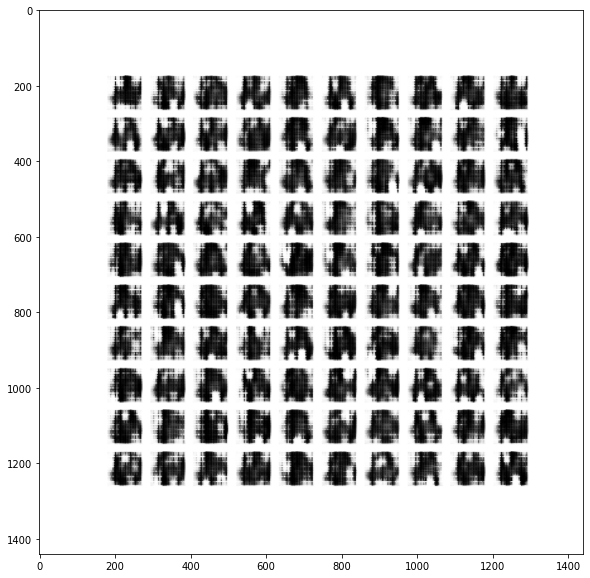

In [41]:
plt.figure(figsize=(10, 10))
plt.imshow(plt.imread('generated_plot_e001.png'))
plt.show()

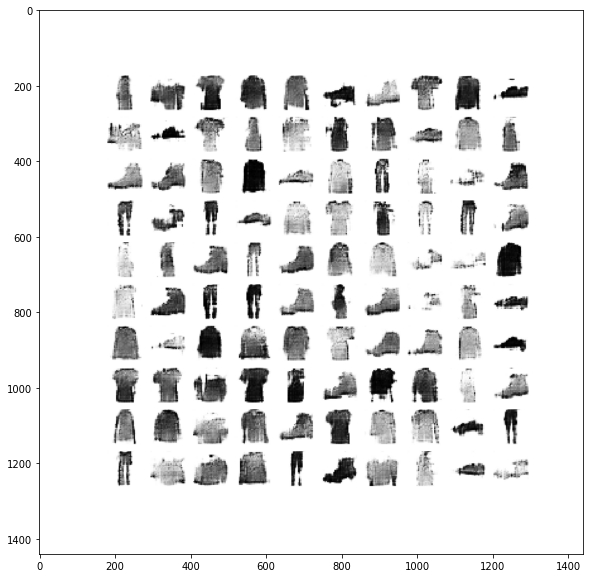

In [42]:
plt.figure(figsize=(10, 10))
plt.imshow(plt.imread('generated_plot_e010.png'))
plt.show()

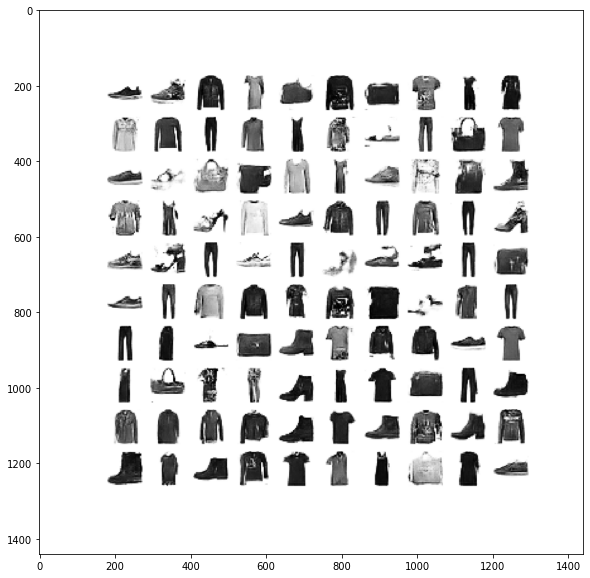

In [43]:
plt.figure(figsize=(10, 10))
plt.imshow(plt.imread('generated_plot_e100.png'))
plt.show()

In [45]:
# vamos a generar imágenes de una determinada clase
from tensorflow.keras.models import load_model

# cargamos el modelo
model = load_model('drive/MyDrive/Master-VIU/06MIAR_Aprendizaje_no_Supervisado/04-Notebooks_de_practicas/Clase_Practica/Extra-GANs_condicionales/'+'cgan_generator_model_100.h5')
# generate images
latent_points, labels = generate_latent_points(100, 100)
# specify labels
labels = np.asarray([x for _ in range(10) for x in range(10)])
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, 100)

4/4 [==============================] - 0s 27ms/step


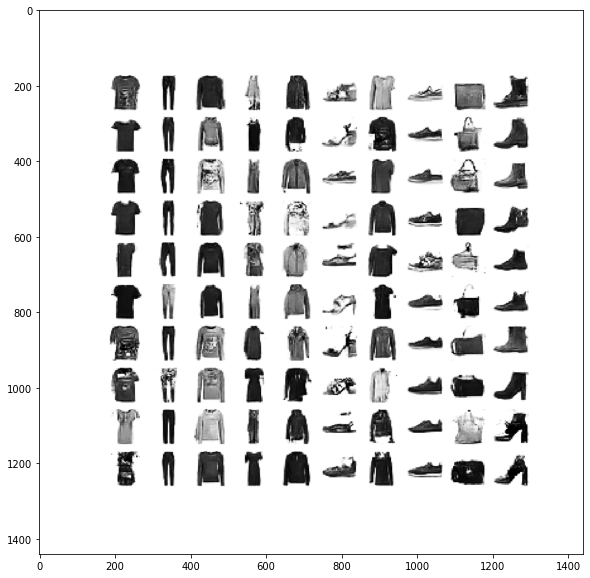

In [46]:
plt.figure(figsize=(10, 10))
plt.imshow(plt.imread('generated_plot_e101.png'))
plt.show()